# Data Preprocessing

**Note: Due to proprietary considerations and data privacy, certain outputs and details have been deleted or anonymized. Only the results necessary to support the research findings are provided, in order to protect information.**

In [2]:
# import necessary libaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
from IPython.display import Javascript
from IPython.display import display
from sklearn.linear_model import LinearRegression
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="should_run_async will not call transform_cell automatically in the future")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [ ]:
# folder directory
%cd '/##'

## Load Conversations.csv file

In [6]:
# Define column names as a list
column_names = ['Conversation_ID', 'Email_Conversation_Count', 'Email_ID_List']

# read file into dataframe
conversation = pd.read_csv('Conversations.csv', header=None, names=column_names)
# conversation

In [7]:
# check total
conversation['Email_Conversation_Count'].sum()

np.int64(92165)

## Load sos_Email.csv file

In [8]:
# Define column names as a list
column_names = ['Email_ID', 'GUID', 'Revision_ID', 'Time_received', 'Subject_Sender', 'Sender_Address', 'Time_Modified', 'Conversation_ID', 'Message_ID', 'Filehash' ]

# read into dataframe
sos_email = pd.read_csv('sos_Email.csv', header=None, names=column_names)
# sos_email
print(sos_email.shape)

(121635, 10)


In [7]:
# check total
sos_email['Email_ID'].nunique()

121635

In [30]:
# inspect some message trend
# sos_email.query('Conversation_ID == "###"')

In [ ]:
# Display the types and check for missing values
print("Data types before conversion:\n", sos_email.dtypes)
print("Missing values:\n", sos_email['Revision_ID'].isna().sum())

## Load sos_Revision.csv file

In [9]:
# Define column names as a list
column_names = ['Revision_ID', 'Email_Registered_By_ID', 'Document_ID', 'Status_ID', 'Revision_No', 'File_Storage_Location', 'File_Realname', 'Locked_Date', 'Locked_Person_ID',
                'Latest_Revision', 'Time_Modify', 'Document_Reference_Number', 'Revision_Date', 'Correspondence_Recipient_Person_ID', 'Correspondence_Sender_ID',
                'Correspondence_Recipient_Office_ID', 'Correspondence_Transmittal_ID', 'Date_Uploaded', 'Title', 'Private_Status', 'File_Size', 'File_Type',
                'Branch_Office_From_ID', 'MD5', 'Approval_Status', 'Drawing_Discipline_ID', 'Deleted_Status', 'Person_ID_Deleted']


# read into dataframe
revision = pd.read_csv('sos_Revision.csv', header=None, names=column_names)
# revision
print(revision.shape)

(185642, 28)


## Load sos_Email_To_Revision.csv File

In [10]:
# Define column names as a list
column_names = ['Email_ID', 'Revision_ID', 'Time_Created', 'Time_Modified']

# read into dataframe
sos_Email_To_Revision = pd.read_csv('sos_Email_To_Revision.csv', header=None, names=column_names)
# sos_Email_To_Revision
print(sos_Email_To_Revision.shape)

(29968, 4)


## Load raw_text.csv File

In [11]:
raw_text = pd.read_csv('raw_text.csv')
# raw_text
print(raw_text.shape)

(172400, 5)


In [13]:
# check unique values
raw_text['Revision_ID'].nunique()

171372

In [14]:
import pandas as pd

# Group by 'Revision_ID' and count each group
grouped = raw_text.groupby('Revision_ID').size()

# Filter groups where count is greater than 1 to find duplicates
duplicates = grouped[grouped > 1]

# Print the duplicates and their counts
print("Duplicate Revision_IDs and their counts:")
# print(duplicates)
print(duplicates.sum())

Duplicate Revision_IDs and their counts:
1868


In [ ]:
raw_text.query('Revision_ID == ####')

In [16]:
# inspect raw text - raw email

# raw_text['raw_text'].iloc[43068]
# raw_text['raw_text'].iloc[249]

# Merging Dataframes

In [18]:
# Merge sos_email with revision on 'Revision_ID', assuming 'revision' contains the correct and complete set of 'Revision_ID'
# Use 'left' merge to keep all records from sos_email and match entries from revision
new_sos_email = pd.merge(sos_email, revision[['Revision_ID', 'Email_Registered_By_ID', 'Document_ID']], on='Revision_ID', how='left')
new_sos_email
print(new_sos_email.shape)

(121635, 12)


In [18]:
# check unique value count
raw_text['Revision_ID'].nunique()

171372

In [19]:
# Merge the two dataframes on 'Email_ID'
merged_df = pd.merge(sos_email, sos_Email_To_Revision[['Email_ID', 'Revision_ID']], on='Email_ID', how='left', suffixes=('', '_from_sos'))

# Fill NaN values in 'Revision_ID' with values from 'Revision_ID_from_sos'
sos_email['Revision_ID'] = sos_email['Revision_ID'].fillna(merged_df['Revision_ID_from_sos'])

# Check if the NaN values are filled
# sos_email
print(sos_email.shape)

(121635, 10)


In [20]:
# check missing values
print("Missing values:\n", sos_email['Revision_ID'].isna().sum())

Missing values:
 12195


In [20]:
# check dataframe
sos_email

In [21]:
# check raw text columns
raw_text

In [ ]:
# check some specific column
sos_email['Subject_Sender'].iloc[121633]

In [ ]:
# check some specific column
raw_text['Title'].iloc[172399]

In [ ]:
# check few rows
sos_email

In [22]:
# check datatypes and non null count
sos_email.info()

In [ ]:
# check datatypes and non null count
raw_text.info()

In [28]:
# sos_email[sos_email.isna().any(axis=1)][:50]

In [23]:
# Step 1: Drop rows where Revision_ID is NaN in sos_email
sos_email_cleaned = new_sos_email.dropna(subset=['Revision_ID'])

# Step 2: Merge with raw_text on Revision_ID
sos_raw_text = pd.merge(sos_email_cleaned, raw_text, on='Revision_ID', how='inner')

# Displaying the first few rows of the merged dataframe to verify
# sos_raw_text
print(sos_raw_text.shape)

(108753, 16)


### Convert Column to their Respective datatype

In [ ]:
# Replace NaN values with 0 in Personel_ID column
sos_raw_text["Email_Registered_By_ID"] = sos_raw_text["Email_Registered_By_ID"].fillna(0)

# Convert columns to integer
sos_raw_text["Email_ID"] = sos_raw_text["Email_ID"].astype(int)
sos_raw_text["Document_ID"] = sos_raw_text["Document_ID"].astype(int)
sos_raw_text["Revision_ID"] = sos_raw_text["Revision_ID"].astype(int)
sos_raw_text["Email_Registered_By_ID"] = sos_raw_text["Email_Registered_By_ID"].astype(int)

# load the csv file
sos_raw_text.to_csv('sos_raw_text.csv', index=False )
sos_raw_text

In [ ]:
# check some revision column
revision

In [ ]:
# load our merged raw text
df = pd.read_csv('sos_raw_text.csv')
df

## Extract Name from Sender Email Address

In [34]:
# Function to extract sender name from email address
def extract_sender_name(email):
    # Extract the part before the '@' symbol
    name_part = email.split('@')[0]
    # Remove digits and non-alphabetic characters except for '.'
    name_part = re.sub(r'[^a-zA-Z\.]', '', name_part)
    # Replace '.' with space and capitalize each part
    return name_part.replace('.', ' ').title()

# Creating new column 'Sender_Name'
df['Sender_Name'] = df['Sender_Address'].apply(extract_sender_name)

In [26]:
# check datatype and non null count
# df.info()
df.shape

(108753, 16)

## Clean Up the Email Content

In [ ]:
# inspect some row
df['raw_text'].iloc[0]

In [37]:
# Footers to remove
footers = [
    '
    ###
    ###
    '
]

# Combine footers into one regex pattern
pattern = '|'.join(footers)

# Function to remove footers
def remove_footers(email):
    return re.sub(pattern, '', email, flags=re.DOTALL | re.IGNORECASE)

def preprocess_email(email):
    # Remove HTML tags and special characters
    email = re.sub(r'<.*?>', ';', email)
    email = re.sub(r'\xa0', ' ', email)
    email = re.sub(r'\[.*?\]', '', email)

    # Replace '\n' or '\n ' preceding a capital letter with '. '
    email = re.sub(r'\n\s*(?=[A-Z])', '. ', email)

    # Normalize whitespace
    email = re.sub(r'\s+', ' ', email).strip()

    # Identify and isolate each email
    email_sections = re.split(r'\sFrom:\s', email)
    email_sections = [e.strip() for e in email_sections if e.strip()]

    # Extract key elements and remove signatures and legal notices
    processed_emails = []
    for section in email_sections:
        header = re.search(r'^(.*?\nTo:.*?\nSubject:.*?\nDate:.*?\n)', section, re.DOTALL | re.IGNORECASE)
        if header:
            header_text = header.group(1)
            body_text = section.replace(header_text, '').strip()
            body_text = re.split(r'Best regards,|Regards,', body_text, flags=re.IGNORECASE)[0].strip()
            processed_emails.append(f"{header_text}\n{body_text}")
        else:
            processed_emails.append(section)

    return "\n\n".join(processed_emails)

# apply preprocessing to each email in the DataFrame
df['processed_raw_text'] = df['raw_text'].apply(remove_footers).apply(preprocess_email)


In [38]:
# Further Preprocessing

def clean_email_content(column):
    # Define the text cleaning function
    def clean_text(text):
        # Step 1: Replace two consecutive periods with one period
        text = re.sub(r'\.\s*\.', '.', text)
        # Step 2: Remove periods following a comma
        text = re.sub(r',\s*\.', ',', text)
        # Step 3: Remove periods following a question mark
        text = re.sub(r'\?\s*\.', '?', text)
        # Step 4: remove any whitespace before a period
        text = re.sub(r'\s+\.', '.', text)
        # Step 5: Replace two consecutive semicolons with one semicolon
        text = re.sub(r'\;\s*\;', ';', text)
        # Step 6: Remove periods following a semicolon
        text = re.sub(r';\s*\.', ';', text)
        # remove extra symbols
        text = re.sub(r'([*_\-])\1{1,}', r'\1\1', text)
        return text

    # Apply the clean_text function to the DataFrame column
    return column.apply(clean_text)

# apply function
df['processed_raw_text'] = clean_email_content(df['processed_raw_text'])

In [ ]:
# Display the processed emails
print(df['processed_raw_text'].iloc[0])

In [ ]:
# inspect some rows
print(df['processed_raw_text'].iloc[10])

In [ ]:
# inspect some rows
print(df['processed_raw_text'].iloc[80])

In [ ]:
# inspect some rows
df['raw_text'].iloc[80]

## Extract Receiver Name from Email Content

In [43]:
# Function to sanitize and format data
def sanitize(text):
    return str(text).replace("'", "").replace('"', '').replace('{', '').replace('}', '').strip()

# Function to extract recipients
def extract_recipients(content):
    recipients = [sanitize(email) for email in content.split(';')]
    return recipients

# Apply the function to the DataFrame
df['Receiver_Name'] = df['processed_raw_text'].apply(extract_recipients)


In [27]:
# check and inspect dataframe
# df

In [ ]:
# inspect some rows
df['Receiver_Name'].iloc[5]

In [ ]:
# inspect some rows
df['Sender_Name'].iloc[4]

### Process the extracted receiver names

In [47]:
# Regular expression to find email addresses
email_regex = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')

def extract_emails(entry):
    if entry is None:  # handle NoneType entries
        return None  # return None or an appropriate value for missing data
    entry_str = str(entry)  # convert entry to string to prevent TypeError
    emails = email_regex.findall(entry_str)
    return ', '.join(emails) if emails else None  # return emails as a comma-separated string or None if no emails found


# apply the function to the DataFrame column
df['receiver_emails'] = df['Receiver_Name'].apply(extract_emails)


In [ ]:
# inspect some rows
df['receiver_emails'].iloc[4]

In [49]:

# Function to process each individual email name
def process_individual_email(email):
    # Split by '@' and take the first part
    name_part = email.split('@')[0]
    # Remove numbers
    name_clean = re.sub(r'\d+', '', name_part)
    # Replace underscores, dashes, and periods with space
    name_no_symbols = re.sub(r'[_\-.]', ' ', name_clean)
    # Split on space and capitalize each part
    name_parts = name_no_symbols.split()
    name_capitalized = ' '.join(part.title() for part in name_parts)
    return name_capitalized

# Function to process email names, handling multiple emails in a single entry
def process_email(emails):
    if emails is None:
        return None  # or return "Unknown" or any other placeholder
    # Split the string on commas to separate multiple emails
    email_list = emails.split(',')
    # Strip whitespace and process each email
    processed_emails = [process_individual_email(email.strip()) for email in email_list]
    # Join processed names back into a single string, or return as a list
    return ', '.join(processed_emails)  # or return processed_emails if list is preferred

# apply the function to the DataFrame column
df['receiver_emails_names'] = df['receiver_emails'].apply(process_email)


In [ ]:
# inspect some rows
df['receiver_emails_names'].iloc[4]

In [51]:
# Function to sanitize and format data
def sanitize(text):
    # Remove unwanted characters and whitespace
    return str(text).replace("'", "").replace('"', '').replace('{', '').replace('}', '').strip()

# Function to extract entries, count words in each entry, and remove entries with more than 3 words
def extract_and_filter_entries(content):
    # Split the content by semicolon to handle multiple entries
    elements = [sanitize(email) for email in content.split(';')]
    # Filter out entries that have more than 3 words
    filtered_elements = [element for element in elements if len(element.split()) <= 3]
    return filtered_elements

# Apply the function to extract names
df['Receiver_Name'] = df['processed_raw_text'].apply(extract_and_filter_entries)

In [ ]:
# inspect some rows
df['Receiver_Name'].iloc[5]

In [ ]:
# function to add the initial receiver names extracted and the one process from the email address
def combine_and_deduplicate(existing_names, new_names_str):
    # Check if new_names_str is None and handle it
    if new_names_str is None:
        new_names = []
    else:
        # Convert new names string to list and remove any extra whitespace
        new_names = [name.strip() for name in new_names_str.split(',')]

    # Combine existing list with new list
    combined_names = existing_names + new_names

    # Remove duplicates using a set to ensure uniqueness
    unique_names = list(set(combined_names))

    return unique_names

# Apply the function to each row
df['Receiver_Name'] = df.apply(lambda row: combine_and_deduplicate(row['Receiver_Name'], row['receiver_emails_names']), axis=1)

# Drop the columns: receiver_emails', 'receiver_emails_names', not needed again
df = df.drop(columns=['receiver_emails', 'receiver_emails_names'])

df


In [54]:
# function to remove sender name from receiver name list
def remove_sender_from_receivers(row):
    # Extract the sender and receivers from the row
    sender = row['Sender_Name']
    receivers = row['Receiver_Name']

    # Clean the receiver list by removing the sender's name
    cleaned_receivers = [name for name in receivers if name != sender]

    return cleaned_receivers

# Apply function
df['Receiver_Name'] = df.apply(remove_sender_from_receivers, axis=1)


# function to remove some unwanted symbols and words, empty strings
def clean_and_filter_names(names):
    cleaned_names = []
    ignore_keywords = ['CN=', 'BYDAY', 'PARTSTAT', 'INTERVAL', 'WKST', 'ROLE', 'RSVP', 'SUMMARY', 'ATTENDEE']
    for name in names:
        # Remove unwanted characters and strip spaces
        name = name.strip(' ,&')

        # Remove any 'Cc:' like prefixes
        if ':' in name:
            name = name.split(':')[-1].strip()

        # Filter out entries with ignore keywords
        if not any(keyword in name for keyword in ignore_keywords):
            # Add to cleaned list if not empty
            if name:
                cleaned_names.append(name)
    return cleaned_names

# Apply function
df['Receiver_Name'] = df['Receiver_Name'].apply(clean_and_filter_names)

# Define a function to remove commas within first name and last name, also remove duplicate names
def duplicate_names_and_commas(names_list):
    # Remove commas and duplicates by converting to set and back to list
    cleaned_list = list(set(name.replace(',', '') for name in names_list))
    return cleaned_list

# Apply function
df['Receiver_Name'] = df['Receiver_Name'].apply(duplicate_names_and_commas)

In [ ]:
# inspect df
df

In [ ]:
# inspect some rows
df['Sender_Name'].iloc[3]

In [ ]:
# inspect some rows
df['Receiver_Name'].iloc[3]

# Rename Needed Columns

In [58]:
df = df.rename(columns={'Title': 'Email_Subject'})
df = df.rename(columns={'processed_raw_text': 'Email_Content'})
df = df.rename(columns={'Time_received': 'Time_Received'})
df = df.rename(columns={'Email_Registered_By_ID': 'Registration_Person_ID'})

In [59]:
# List of columns to select
selected_columns = ['Conversation_ID', 'Revision_ID', 'Email_ID', 'Document_ID', 'Sender_Name', 'Sender_Address', 'Email_Subject', 'Email_Content', 'Receiver_Name', 'Time_Received', 'Time_Modified',  'Registration_Person_ID',]

In [60]:
# Selecting the specified columns
processed_emails = df[selected_columns]

In [29]:
# load the processed file
processed_emails.to_csv('processed_sos_raw_text.csv', index=False)
processed_emails = pd.read_csv('processed_sos_raw_text.csv')
processed_emails.shape

(108753, 12)

## Total word count of the Dataset (Processed Emails)

In [62]:
# Convert all DataFrame values to a single string
processed_emails = ' '.join(processed_emails.astype(str).values.flatten())

# Split the text into words and count them
total_word_count = len(processed_emails.split())

print("Total word count:", total_word_count)

Total word count: 48418329


In [66]:
# inspect some rows
processed_emails['Email_Content'].iloc[15493]

# Further Data Exploration Analysis

## Word Cloud Visualization for Email Content, Sender, and Receiver

The aim is to visualize the most frequent words in the email content,  Sender, and Receiver column of the proprocessed email dataframe by generating a word cloud.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# function to plot word cloud (Email Content)
def plot_word_cloud(df, column_name):
    # Concatenate all text in the specified column into a single string
    words = ' '.join(df[column_name].dropna())

    if words:  # Check if there are any words to plot
        # Generate the word cloud
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=3000, height=2500).generate(words)

        # Plot the word cloud
        plt.figure(figsize=(8, 8))
        plt.imshow(wordcloud, interpolation='bilinear')

        # Set the background color of the figure and axes
        plt.gcf().set_facecolor('black')
        plt.gca().set_facecolor('black')

        # Add the title based on the sentiment
        plt.title(f'Word Cloud for {column_name.capitalize()} Email Content\n', color='white')

        # Turn off axis
        plt.axis('off')

        # Show the plot
        plt.show()
    else:
        print("No words to display. Check the DataFrame and column name.")

#call to the function
plot_word_cloud(df, 'Email_Content')


In [68]:
# function to plot word (Sender)
def plot_word_cloud(df, column_name):
    # Concatenate all text in the specified column into a single string
    words = ' '.join(df[column_name].dropna())

    if words:  # Check if there are any words to plot
        # Generate the word cloud
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=3000, height=2500).generate(words)

        # Plot the word cloud
        plt.figure(figsize=(8, 8))
        plt.imshow(wordcloud, interpolation='bilinear')

        # Set the background color of the figure and axes
        plt.gcf().set_facecolor('black')
        plt.gca().set_facecolor('black')

        # Add the title based on the sentiment
        plt.title(f'Word Cloud Representation for Email Sender\n', color='white')

        # Turn off axis
        plt.axis('off')

        # Show the plot
        plt.show()
    else:
        print("No words to display. Check the DataFrame and column name.")

# call to the function
plot_word_cloud(df, 'Sender_Name')

In [69]:
# function to plot word cloud (Receiver)
def plot_word_cloud(df, column_name):
    # Flatten all lists of names into a single list
    all_names = [name for sublist in df[column_name].dropna() for name in sublist]

    if all_names:  # Check if there are any names to plot
        # Calculate word frequencies for the full names
        word_counts = Counter(all_names)

        # Remove top 20 most frequent words
        for word, _ in word_counts.most_common(0):
            del word_counts[word]

        # Generate the word cloud with remaining words
        wordcloud = WordCloud(background_color='black', width=3000, height=2500, collocations=False).generate_from_frequencies(word_counts)

        # Plot the word cloud
        plt.figure(figsize=(8, 8))
        plt.imshow(wordcloud, interpolation='bilinear')

        # Set the background color of the figure and axes
        plt.gcf().set_facecolor('black')
        plt.gca().set_facecolor('black')

        # Add the title based on the column name
        plt.title(f'Word Cloud Representation for Email Recipients\n', color='white')

        # Turn off axis
        plt.axis('off')

        # Show the plot
        plt.show()
    else:
        print("No names to display. Check the DataFrame and column name.")

# Call to the function
plot_word_cloud(df, 'Receiver_Name')


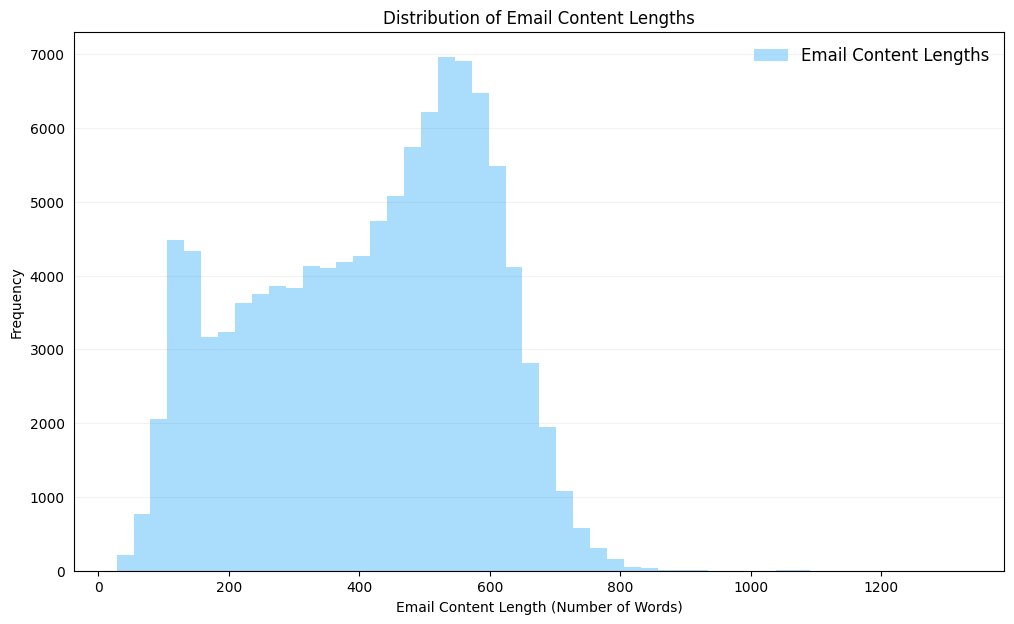

In [71]:
# plot Histogram

# Calculate the length of each email content in terms of number of words
df['email_content_length'] = df['Email_Content'].apply(lambda x: len(x.split()))

# Plot the distribution of email content lengths
plt.figure(figsize=(12, 7))

# Create a histogram for the lengths of email content
plt.hist(df['email_content_length'], bins=50, color='#87CEFA', alpha=0.7, label='Email Content Lengths')

# Set the background color of the figure and axes to white
plt.gcf().set_facecolor('white')
plt.gca().set_facecolor('white')

# Setting labels, title, and ticks with appropriate color for dark text
plt.xlabel('Email Content Length (Number of Words)', color='black')
plt.ylabel('Frequency', color='black')
plt.title('Distribution of Email Content Lengths', color='black')
plt.tick_params(colors='black', which='both')  # Change the colors of the ticks to black

# adding faint horizontal grid lines for better readability
plt.grid(axis='y', linestyle='-', alpha=0.1, color='grey')

# Remove y-tick lines for cleaner aesthetics
plt.tick_params(axis='y', which='both', left=False)

# Add a legend with black text
plt.legend(frameon=False, facecolor='none', edgecolor='none', fontsize=12, labelcolor='black')

# Show plot
plt.show()
